### Cournot Duopoly

- There are two firms that interact in repeated Cournot duopoly game.
- Costs: c1,c2
- Demand: P = 1-Q

#### Cases:
- No discounting, no state
- Discounting and no state
- Discoutning and state

### Packages

In [255]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20
import numpy as np
np.set_printoptions(precision=3)

### Cournot Game

In [256]:
def P(Q):
    return max(1-Q,0)
    
class firm:
    def __init__(self, c):
        self.c = c
    
    def profit(self,p,q):
        return (p-self.c)*q
    
    def bestresponse(self, q_other):
        return (1-q_other-self.c)/2 
    
def profit(q1,q2):
    return (P(q1+q2)-c1)*q1,(P(q1+q2)-c2)*q2

def competition(c1,c2):
    q1c = (1+c2-2*c1)/3
    q2c = (1+c1-2*c2)/3
    Qc = q1c + q2c
    Pc = P(Qc)
    return q1c, q2c, Pc, Qc

def monopoly(c1,c2):
    if c1<c2:
        Qm = (1-c1)/2
        Pm = (1+c1)/2
    if c1<=c2:
        Qm = (1-c2)/2
        Pm = (1+c2)/2
    return Qm,Pm

def gameReward(q1,q2):
    Q = q1 + q2
    p = P(Q)
    π1 = firm1.profit(p,q1)
    π2 = firm2.profit(p,q2)
    return (π1,π2)

def generateGame(c1, c2):
    firm1 = firm(c1)
    firm2 = firm(c2)
    q1c, q2c, Pc, Qc = competition(c1,c2)
    print('Competition', Qc, Pc)
    Qm,Pm = monopoly(c1,c2)
    print('Monopoly', Qm, Pm)
    return q1c, q2c, Pc, Qc, Qm, Qc

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [257]:
c1, c2 = 0.1,0.1
firm1 = firm(c1)
firm2 = firm(c2)
q1c, q2c, Pc, Qc = competition(c1,c2)
Qm,Pm = monopoly(c1,c2)
Qgrid = np.linspace(0,Qc,10)
print(Qm,Qc, Qgrid)

0.45 0.6000000000000001 [0.    0.067 0.133 0.2   0.267 0.333 0.4   0.467 0.533 0.6  ]


In [258]:
firm1.profit(Pc,q1c), firm2.profit(Pc,q2c)

(0.09, 0.09)

In [259]:
def gameReward(q1,q2):
    Q = q1 + q2
    p = P(Q)
    π1 = firm1.profit(p,q1)
    π2 = firm2.profit(p,q2)
    return (π1,π2)


### Memory, Q-Network

In [ ]:
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   

def select_action(state, policy_net, idx, n_actions):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice(list(range(n_actions)))
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')
    

def train():
    global n_actions, state, policy_net1, policy_net2, memory
    global optimizer2, optimizer1, target_net1, target_net2, Qgrid
    global BATCH_SIZE, GAMMA, EPS_START, EPS_END, EPS_DECAY, TAU, LR
    global n_obs, n_actions, c1, c2, q1c, q2c, Pc, Qc, Qm, Qc, Qgrid, epochs

    for t in range(epochs):
        print('Iteration',t)
        
        # Take action
        a1 = select_action(state, policy_net1, 0, n_actions)
        a2 = select_action(state, policy_net2, 1, n_actions)
        q1 = Qgrid[a1]
        q2 = Qgrid[a2]
        
        # Obtain Rewards
        r1, r2 = gameReward(q1,q2)
        r1 = torch.tensor([r1])
        r2 = torch.tensor([r2])

        # Compute next state
        next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

        # store memory in transition
        memory.push(state,next_state,a1,a2,r1,r2)

        # move to next state
        state = next_state

        # optimize
        optimize_model(policy_net1,target_net1, 0)
        optimize_model(policy_net2,target_net2, 1)

        # soft update target_net
        update_target_net(target_net1, policy_net1)
        update_target_net(target_net2, policy_net2)
        
        # record actions
        actions.append([a1.item(),a2.item()])
        prices.append(P(q1+q2))
        quantities.append(1-P(q1+q2))

### Case 1 - No discounting, No memory

In [337]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.2 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-5 # Learning rate of Adam

n_obs = 1 # size of memory
n_actions = 6 # action space
c1, c2 = 0.1,0.1
q1c, q2c, Pc, Qc, Qm, Qc = generateGame(c1, c2)
Qgrid = np.linspace(c1, q1c+0.05, n_actions)
print(Qgrid)

policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
prices = []
quantities = []
epochs = 1000

Competition 0.6000000000000001 0.3999999999999999
Monopoly 0.45 0.55
[0.1  0.15 0.2  0.25 0.3  0.35]


In [338]:
train()

Loss Agent0:0.004820432361891267
Loss Agent1:0.004292500017744108
Loss Agent0:0.004779808724673925
Loss Agent1:0.004106817958309648
Loss Agent0:0.004739684194497994
Loss Agent1:0.004071147310072826
Loss Agent0:0.004700032972185909
Loss Agent1:0.00395473789966283
Loss Agent0:0.004660835716521383
Loss Agent1:0.0038303105080215033
Loss Agent0:0.004613141746369648
Loss Agent1:0.0037430348977382
Loss Agent0:0.004297603431074737
Loss Agent1:0.0036924429411712223
Loss Agent0:0.004545506294443788
Loss Agent1:0.0035347336087762824
Loss Agent0:0.004230266954938767
Loss Agent1:0.0034513031263528563
Loss Agent0:0.0047334621119964875
Loss Agent1:0.0033332371294000104
Loss Agent0:0.004372581356680703
Loss Agent1:0.0032359109246360785
Loss Agent0:0.0046460569614381175
Loss Agent1:0.003147161588421465
Loss Agent0:0.004305727279273344
Loss Agent1:0.0030524280155751144
Loss Agent0:0.0037517315310431404
Loss Agent1:0.002942830783748745
Loss Agent0:0.003977695712599497
Loss Agent1:0.0028746512471600474
Lo

Loss Agent0:0.0017613536849983014
Loss Agent1:0.00040018125962728413
Loss Agent0:0.0017990810345420035
Loss Agent1:0.0006874737193359589
Loss Agent0:0.0019148057135606605
Loss Agent1:0.00046198520874047016
Loss Agent0:0.0017967091133326018
Loss Agent1:0.00032358799546124465
Loss Agent0:0.002004465189914667
Loss Agent1:0.0005567400004939974
Loss Agent0:0.001277688956712076
Loss Agent1:0.0005207952886772903
Loss Agent0:0.0013434275328845287
Loss Agent1:0.0004742215725834835
Loss Agent0:0.0015599220298904192
Loss Agent1:0.0006112709798333795
Loss Agent0:0.001397639216129908
Loss Agent1:0.0004584745519148431
Loss Agent0:0.0014217222406966807
Loss Agent1:0.0005021125251932242
Loss Agent0:0.0011216940034491764
Loss Agent1:0.0004992210318871166
Loss Agent0:0.0014617031321619792
Loss Agent1:0.00041300556633335573
Loss Agent0:0.001729297075564204
Loss Agent1:0.0004903273716493593
Loss Agent0:0.0013659363557280016
Loss Agent1:0.00041501306580915516
Loss Agent0:0.0012893152223286864
Loss Agent1:0

Loss Agent0:0.0008475478504471444
Loss Agent1:0.00029586971592840205
Loss Agent0:0.000811325651508664
Loss Agent1:0.0001901585202307143
Loss Agent0:0.0008917507484840816
Loss Agent1:0.00020008209928831306
Loss Agent0:0.0010723855897510546
Loss Agent1:0.0001859662015204934
Loss Agent0:0.0006952936365409641
Loss Agent1:0.0002571113806516223
Loss Agent0:0.0007255486222097365
Loss Agent1:0.00022773427303316514
Loss Agent0:0.0006014147892857236
Loss Agent1:0.00025288408461410694
Loss Agent0:0.0009969084216745624
Loss Agent1:0.00018974133767312774
Loss Agent0:0.0009093065235155782
Loss Agent1:0.00027882217557861216
Loss Agent0:0.0008047834505401419
Loss Agent1:0.00020353443519418026
Loss Agent0:0.0008239239589685079
Loss Agent1:0.00027336020408950517
Loss Agent0:0.0007577355658668519
Loss Agent1:0.0002191702307771344
Loss Agent0:0.0006420821808388292
Loss Agent1:0.000211291649248293
Loss Agent0:0.000815371051407008
Loss Agent1:0.00012937143966542986
Loss Agent0:0.0007703046866183711
Loss Age

Loss Agent0:0.0005009322116971715
Loss Agent1:0.00014206852495030005
Loss Agent0:0.0005737590764687695
Loss Agent1:0.00010651467172253219
Loss Agent0:0.0005152770985041399
Loss Agent1:0.0001472066630127839
Loss Agent0:0.0005330961017405261
Loss Agent1:0.00023894973551138435
Loss Agent0:0.0005796547963577154
Loss Agent1:7.659791138667641e-05
Loss Agent0:0.0005373412585228253
Loss Agent1:0.0001845924824528076
Loss Agent0:0.00046696392094496485
Loss Agent1:0.00011451974585143139
Loss Agent0:0.0005648910073843864
Loss Agent1:0.00014530860122511125
Loss Agent0:0.0005526937577643682
Loss Agent1:7.486538354868451e-05
Loss Agent0:0.0006490873305156448
Loss Agent1:0.00015167590635573885
Loss Agent0:0.0005454034611765871
Loss Agent1:9.777180613726473e-05
Loss Agent0:0.0005989844315067731
Loss Agent1:0.00012911308574473866
Loss Agent0:0.0005094849411721506
Loss Agent1:0.00021754336686066086
Loss Agent0:0.0005814245851350815
Loss Agent1:9.421382868699191e-05
Loss Agent0:0.0004823021941776054
Loss 

Loss Agent0:0.00042355699636823917
Loss Agent1:7.028094580749185e-05
Loss Agent0:0.00044018525035230437
Loss Agent1:0.00012114429681954369
Loss Agent0:0.0004643678922207374
Loss Agent1:8.290794595049058e-05
Loss Agent0:0.00045988297280963515
Loss Agent1:8.775549414386053e-05
Loss Agent0:0.00042679080432722665
Loss Agent1:8.671631255226544e-05
Loss Agent0:0.00040760133886660036
Loss Agent1:8.287610581882884e-05
Loss Agent0:0.00044003789648131
Loss Agent1:7.217794815760821e-05
Loss Agent0:0.0004719855609725313
Loss Agent1:7.313307364681826e-05
Loss Agent0:0.00044459635534235223
Loss Agent1:7.249576274576877e-05
Loss Agent0:0.00039899905699198354
Loss Agent1:8.923735517548402e-05
Loss Agent0:0.0004093997324676869
Loss Agent1:0.00010527048650653219
Loss Agent0:0.0004601425084313632
Loss Agent1:5.4765562480543664e-05
Loss Agent0:0.0004236211735702797
Loss Agent1:0.00014116275158705235
Loss Agent0:0.0003994569929384607
Loss Agent1:7.424434651553337e-05
Loss Agent0:0.0004231734997637526
Loss 

Loss Agent0:0.00034461150835967487
Loss Agent1:7.891657965653668e-05
Loss Agent0:0.00034987295356920747
Loss Agent1:9.638170453386586e-05
Loss Agent0:0.00041064754793578007
Loss Agent1:3.256340848003173e-05
Loss Agent0:0.0003386774396319926
Loss Agent1:5.097486091649441e-05
Loss Agent0:0.0003503249607155896
Loss Agent1:4.03176250499055e-05
Loss Agent0:0.000368562131443817
Loss Agent1:5.47077309834276e-05
Loss Agent0:0.000327614964957986
Loss Agent1:8.009089695495778e-05
Loss Agent0:0.00034178618926088584
Loss Agent1:3.7808720866238576e-05
Loss Agent0:0.000340878062610745
Loss Agent1:7.472604846997061e-05
Loss Agent0:0.0003632301649856256
Loss Agent1:8.243494973372002e-05
Loss Agent0:0.0003518559469715412
Loss Agent1:9.100974758624016e-05
Loss Agent0:0.00038122511442965776
Loss Agent1:6.773944329071082e-05
Loss Agent0:0.0003792648123589969
Loss Agent1:6.99988235897284e-05
Loss Agent0:0.0003415083878004552
Loss Agent1:4.233855446319418e-05
Loss Agent0:0.00043074555356556265
Loss Agent1:7

Loss Agent0:0.00027636418775286406
Loss Agent1:4.193274272172219e-05
Loss Agent0:0.00030837964886430133
Loss Agent1:6.868678044099269e-05
Loss Agent0:0.00033219496050023513
Loss Agent1:0.00011589211552551828
Loss Agent0:0.00035177511419363813
Loss Agent1:7.597869884452688e-05
Loss Agent0:0.0003382138829505378
Loss Agent1:9.586559507410275e-05
Loss Agent0:0.0003263411034899383
Loss Agent1:7.337013836915334e-05
Loss Agent0:0.0003733564682965094
Loss Agent1:3.7592480232875725e-05
Loss Agent0:0.00033216047168183104
Loss Agent1:5.8931209117805946e-05
Loss Agent0:0.0003489138087409124
Loss Agent1:4.87987879269145e-05
Loss Agent0:0.00031605675916476474
Loss Agent1:7.130194171389526e-05
Loss Agent0:0.000362471092906453
Loss Agent1:6.705391381292714e-05
Loss Agent0:0.00027560485503890875
Loss Agent1:0.00013541390277890903
Loss Agent0:0.000298786301820237
Loss Agent1:4.7517416950474336e-05
Loss Agent0:0.00036156621720686395
Loss Agent1:3.3939847813964346e-05
Loss Agent0:0.0003118011226674087
Los

Loss Agent0:0.0003526613799655811
Loss Agent1:6.768709535133347e-05
Loss Agent0:0.0003409348872208815
Loss Agent1:8.854775847255508e-05
Loss Agent0:0.00032492572576554624
Loss Agent1:9.261791660846941e-05
Loss Agent0:0.0003401657843966531
Loss Agent1:0.00010474852670171013
Loss Agent0:0.0003174638159922423
Loss Agent1:3.901302307289366e-05
Loss Agent0:0.00035735071764239574
Loss Agent1:7.050057770484554e-05
Loss Agent0:0.00031715821164203083
Loss Agent1:5.9811667934154926e-05
Loss Agent0:0.0003238588923207632
Loss Agent1:4.997555252247987e-05
Loss Agent0:0.0002973702016196046
Loss Agent1:5.1025410872906024e-05
Loss Agent0:0.00031511834051351287
Loss Agent1:4.969030386454426e-05
Loss Agent0:0.00033984045934559444
Loss Agent1:3.7579751348561066e-05
Loss Agent0:0.00029938180857049955
Loss Agent1:9.62655779335248e-05
Loss Agent0:0.0002815551492247016
Loss Agent1:0.00011074472150562602
Loss Agent0:0.000330427191518808
Loss Agent1:9.51057340946273e-05
Loss Agent0:0.0003124981237987521
Loss A

In [339]:
policy_net1(state), policy_net2(state)

(tensor([0.0546, 0.0722, 0.0881, 0.1058, 0.1065, 0.0995],
        grad_fn=<AddBackward0>),
 tensor([0.0515, 0.0682, 0.0723, 0.0852, 0.0931, 0.0800],
        grad_fn=<AddBackward0>))

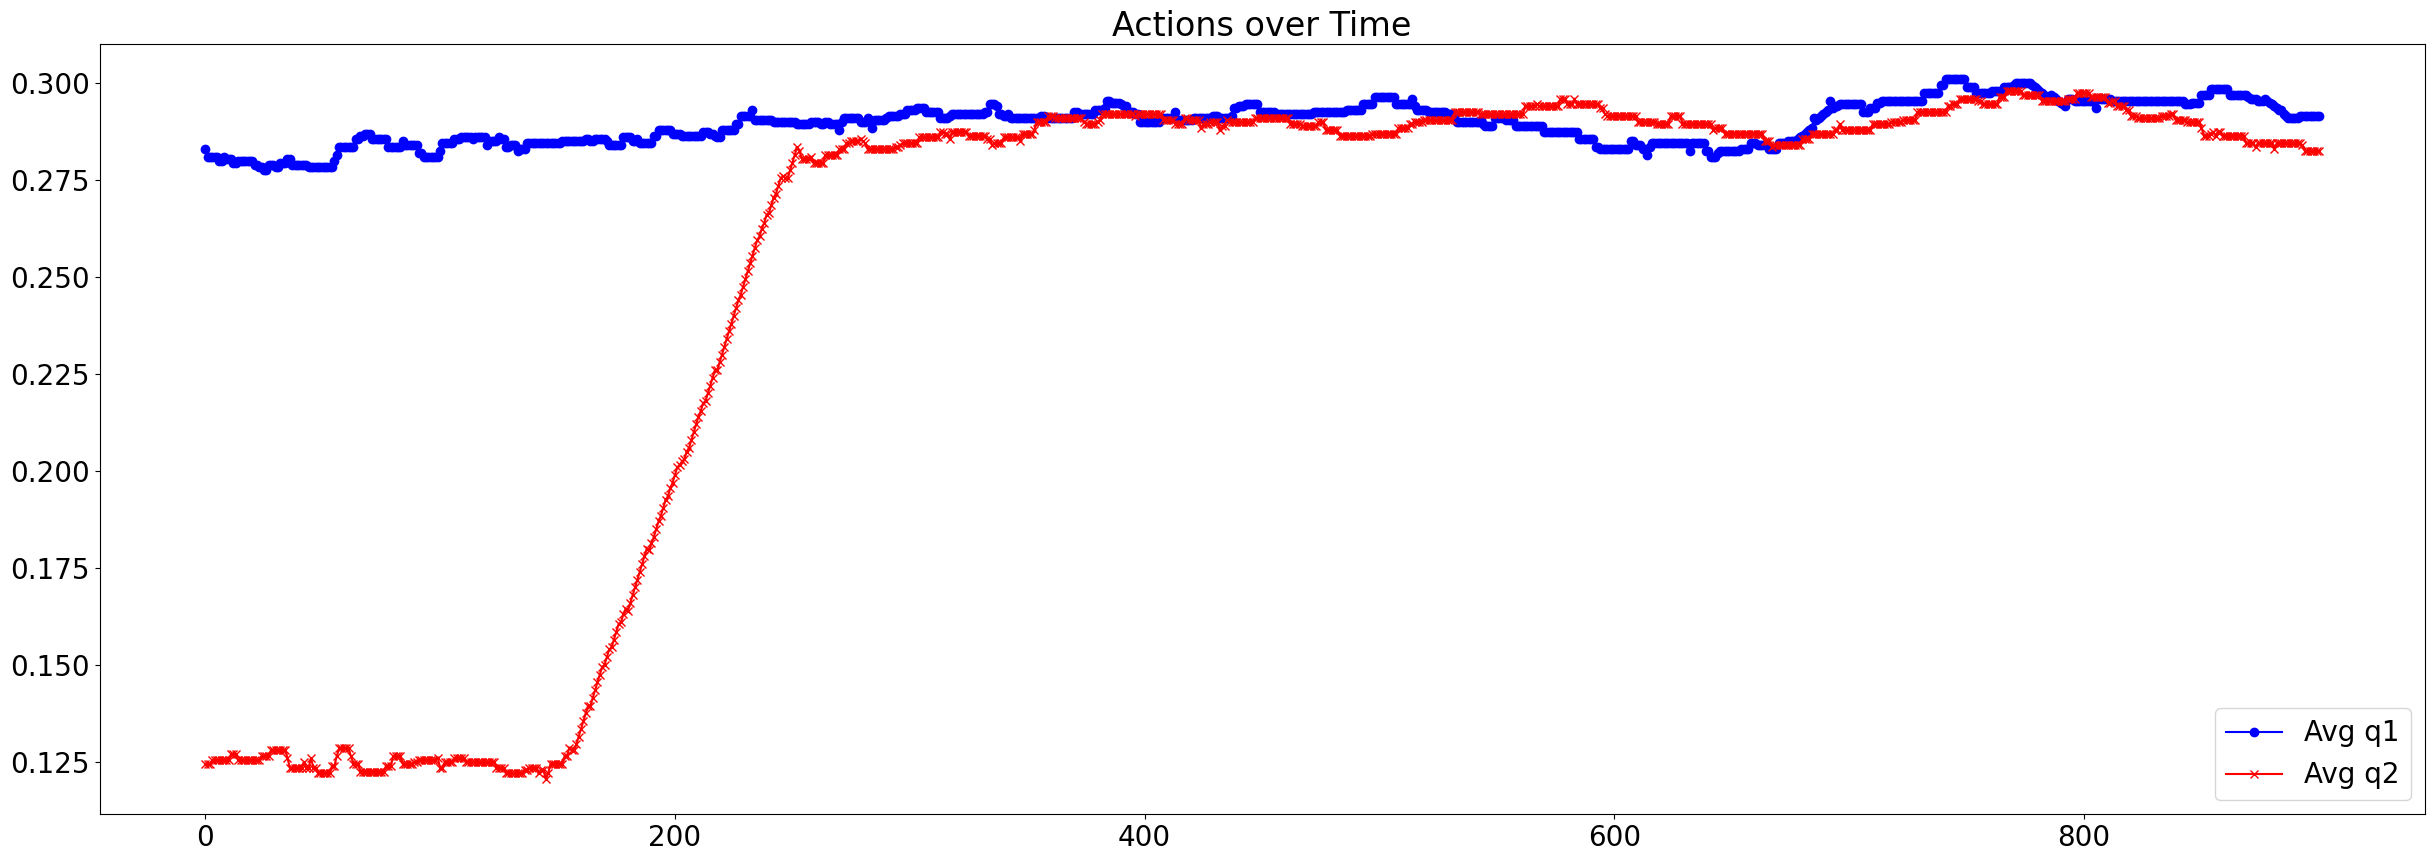

In [340]:
plt.plot(moving_average(Qgrid[np.array(actions)][:,0],100), label = 'Avg q1', marker = 'o', c = 'b')
plt.plot(moving_average(Qgrid[np.array(actions)][:,1],100), label = 'Avg q2', marker = 'x', c = 'r')
plt.legend()
plt.title('Actions over Time')
plt.show()

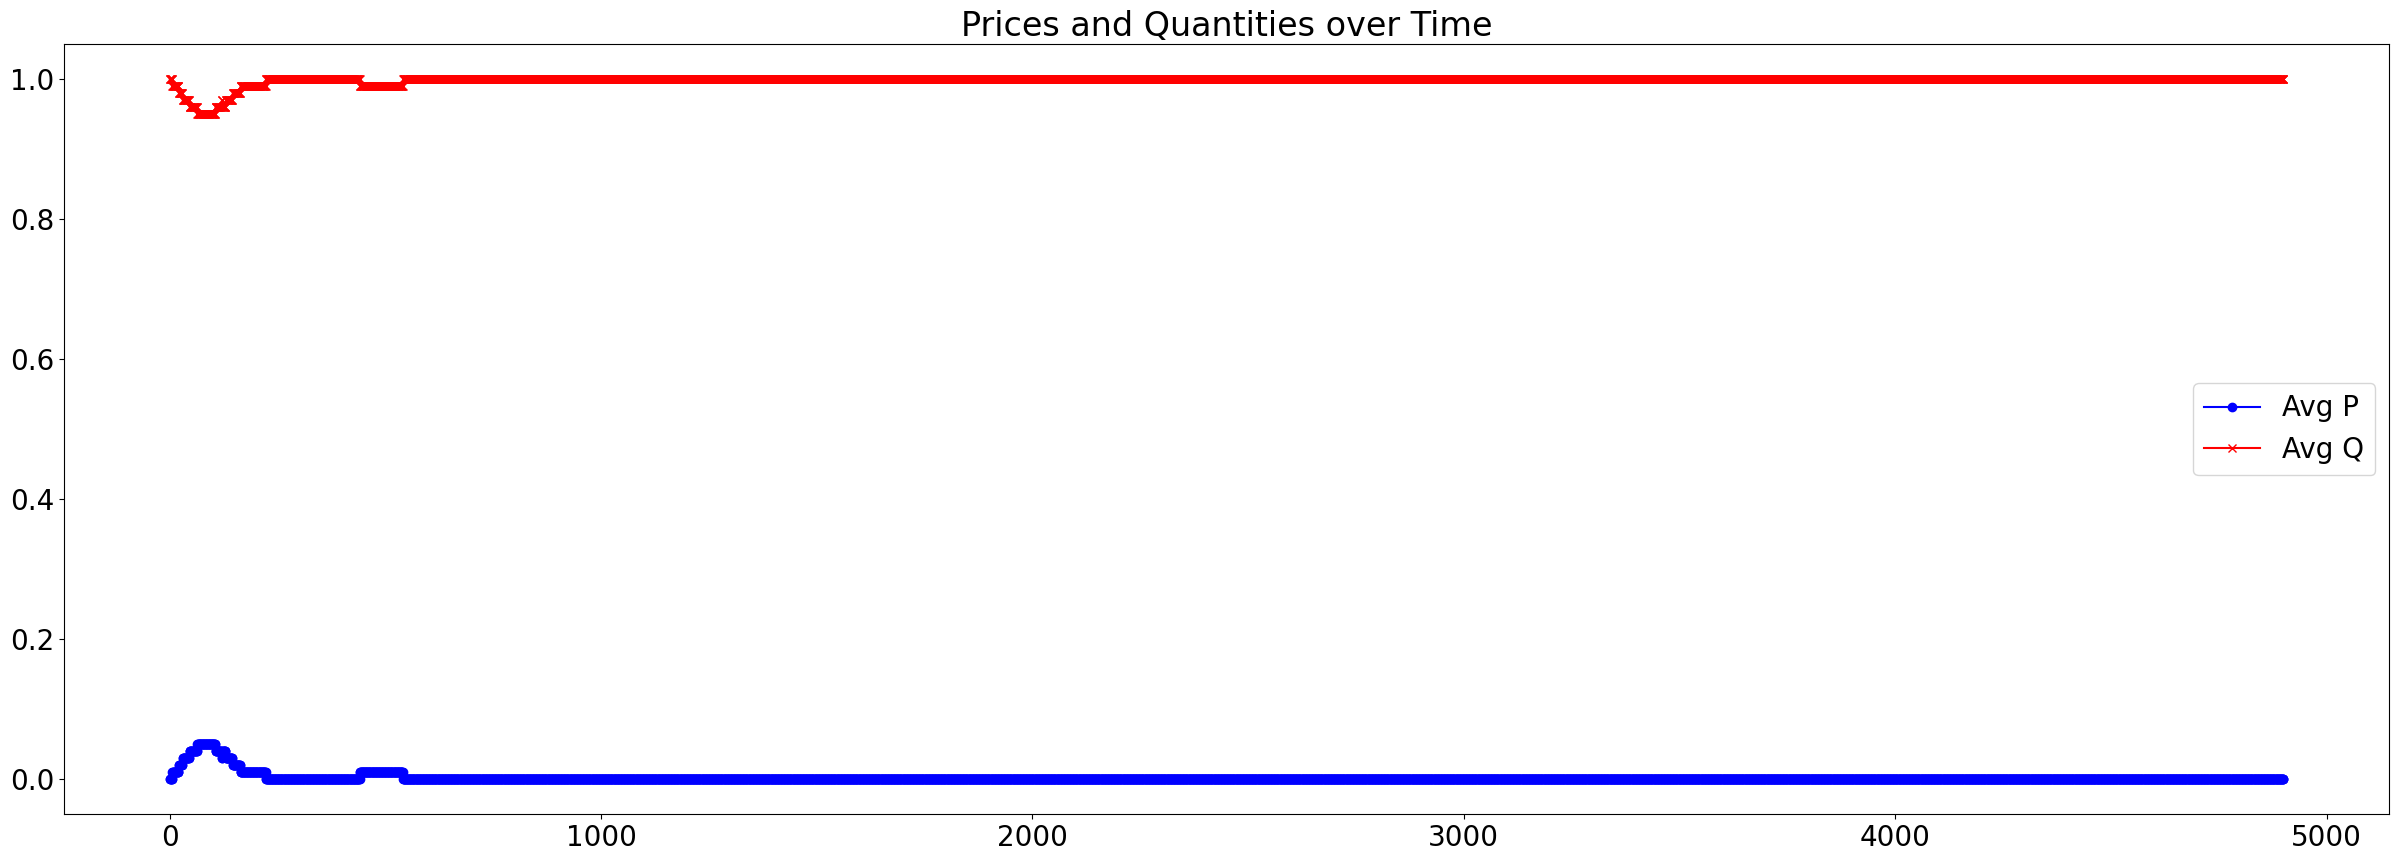

In [324]:
plt.plot(moving_average(np.array(prices),100), label = 'Avg P', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(quantities),100), label = 'Avg Q', marker = 'x', c = 'r')
plt.legend()
plt.title('Prices and Quantities over Time')
plt.show()

### Case 2 - Discounting, No Memory

### Case 3 - Discounting, Memory

In [325]:
prices

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
